# Prepare the Datatset and Collect Data
1. Transform time series into frequency domain
2. Resample the frequency spectra to the same lengths
2. Flatten the $N_s \times 16$ frequency matrix into a 1D vector
3. Stack the frequency vectors into a frequency matrix

In [1]:
import glob
import os
import re

import numpy as np
import pandas as pd
from bidict import bidict
from numpy.fft import rfft
from scipy.signal import resample
from skfda import FDataGrid
from skfda.representation.basis import Fourier
from torch.utils.data import Dataset
from torchvision import transforms


class Texture:
    """Create a bidict from a texture name list."""

    def __init__(self, texture_names):
        self.texture_by_id = bidict()
        for i, tn in enumerate(set(texture_names)):
            self.texture_by_id[tn] = i

    def get_id(self, texture_name: str):
        return self.texture_by_id[texture_name]

    def get_name(self, texture_id: int):
        return self.texture_by_id.inverse[texture_id]


class TacDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.filelist = [
            y for x in os.walk(root_dir) for y in glob.glob(os.path.join(x[0], "*.csv"))
        ]
        self.params = [(0.0, 0.0)] * len(self.filelist)
        self.texture_names = []
        for i, filename in enumerate(self.filelist):
            basename = os.path.basename(filename)
            namegroups = basename.split("_")

            self.texture_names.append(namegroups[0])
            self.params[i] = [
                int(re.search(r"\d+", namegroups[1]).group(0)),
                float(re.search(r"[-+]?\d+", namegroups[2]).group(0)),
            ]
        self.textures = Texture(self.texture_names)

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, index):
        filename = self.filelist[index]
        rawdata = np.genfromtxt(filename, delimiter=",", skip_header=1)
        tacdata = rawdata[:, 3:]
        texture_name = self.texture_names[index]
        if self.transform:
            tacdata = self.transform(tacdata)
        return tacdata, self.params[index], self.textures.get_id(texture_name)

    def count_class(self):
        return len(set(self.texture_names))

    def get_texture_name(self, texture_id):
        return self.textures.get_name(texture_id)


""" Custom transforms """


class Normalize(object):
    def __init__(self, axis=0):
        self.axis = axis

    def __call__(self, sample):
        return (sample - np.mean(sample, keepdims=True)) / np.std(sample, keepdims=True)


class ResampleFFT(object):
    def __init__(self, Ns, flatten=True, axis=0):
        self.Ns = Ns
        self.axis = axis
        self.flatten = flatten

    def __call__(self, x):
        y = rfft(x, axis=self.axis, norm="ortho")
        ys = np.abs(y)[1:, :]
        ys = resample(ys, self.Ns, axis=self.axis)
        if self.flatten:
            ys = ys.flatten()

        return ys


transform = transforms.Compose([Normalize(axis=1), ResampleFFT(32)])
ds = TacDataset("data", transform=transform)

""" Collect data and labels """
coeff_array = []
labels = []

for sample, param, label in ds:
    coeff_array.append(sample)
    texture, (p, s) = ds.get_texture_name(label), param
    labels.append((texture, label, p, s))

df_label = pd.DataFrame(labels, columns=["texture", "id", "pressure", "speed"])
coeffs = np.asarray(coeff_array)

/home/alex/miniconda3/envs/tac3d/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Utility Functions

In [12]:
import matplotlib.pyplot as plt
from matplotlib import colormaps


def split_train_test(x, y, use_texture=2, random_texture=True):
    """split textures into (train, test and other) 3 groups"""

    all_tex = y[~y["texture"].str.contains("Board")]["texture"].unique()
    if random_texture:
        np.random.shuffle(all_tex)

    def get_set(select):
        index = y[y["texture"].isin(select)].index
        label = y.iloc[index]
        coeff = x[index, :]

        label.reset_index(drop=True, inplace=True)

        return coeff, label

    select_train = all_tex[use_texture]
    select_test = [e for e in all_tex if e not in select_train]
    select_other = y[y["texture"].str.contains("Board")]["texture"].unique()

    train_x, train_y = get_set(select_train)
    test_x, test_y = get_set(select_test)
    other_x, other_y = get_set(select_other)

    return train_x, train_y, test_x, test_y, other_x, other_y


""" Ploting funtions """


def plot3d(x, y, items, selected=None, ax=None, marker=None):
    if type(x) == pd.DataFrame:
        x = x.values
    df1 = pd.DataFrame(x[:, :3], columns=["x", "y", "z"])
    try:
        y = y.values
    except:
        y = y
    df2 = pd.DataFrame(y, columns=["texture", "id", "pressure", "speed"])
    df = pd.concat([df2, df1], axis=1)
    return plot3df(df, items, selected, ax, marker)


def plot3df(df, items, selected, ax, marker):
    if selected is not None:
        df = df[df[items].isin(selected)]
    unique_item = df_label[items].unique()
    cmap = plt.get_cmap("Set1", len(unique_item))
    colors = dict([(unique_item[i], cmap(i)) for i in range(len(unique_item))])

    if ax == None:
        ax = plt.figure().add_subplot(projection="3d")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    for item in df[items].unique():
        df_ = df[df[items] == item]
        color = np.asarray(colors[item])
        ax.scatter(
            df_["x"],
            df_["y"],
            df_["z"],
            marker="." if marker is None else marker,
            s=25 if len(df) > 1 else 40,
            c=np.tile(color, (len(df_), 1)),
            label=item,
        )
        ax.view_init(0, 90, 0)
    plt.tight_layout()

    return colors

# Iterative Feature Extractor in Frequency Domain
1. Use few samples as a prior knowledge to train a PCA compressor ($Ns \times 16$-D $\rightarrow n-$D)
2. For new samples, update the de-meaned frequency matrix
3. Apply iterative PCA to update the compressed frequency vector
4. Try to identify the fabric material under current *pressure* and *speed* settings

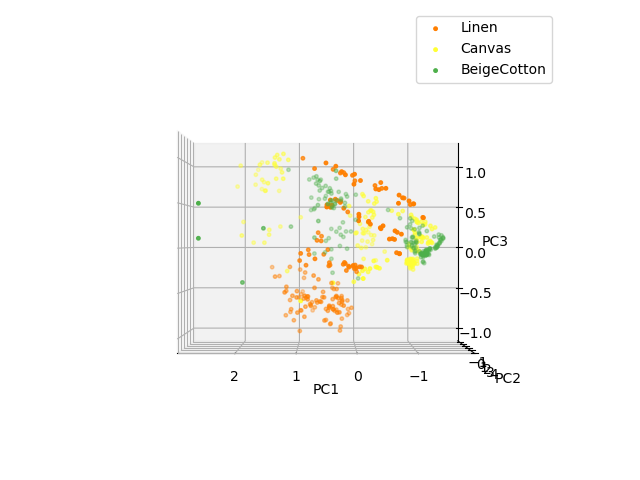

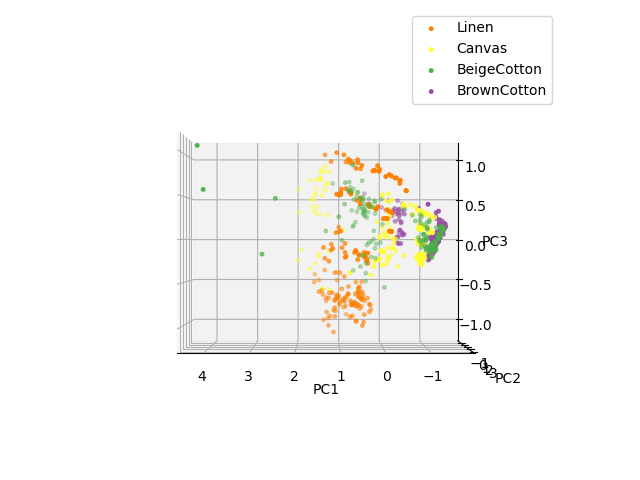

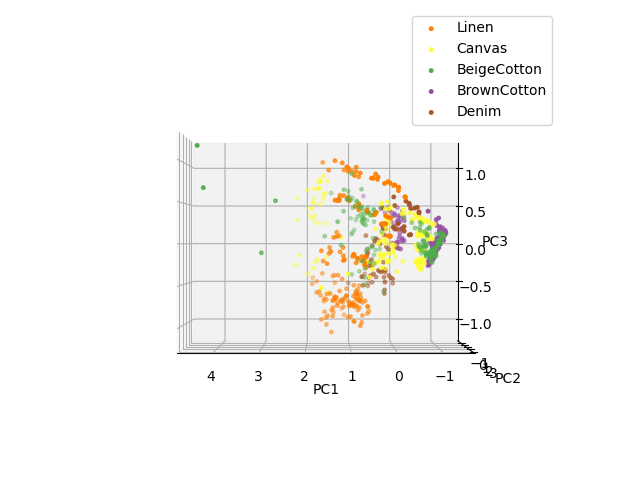

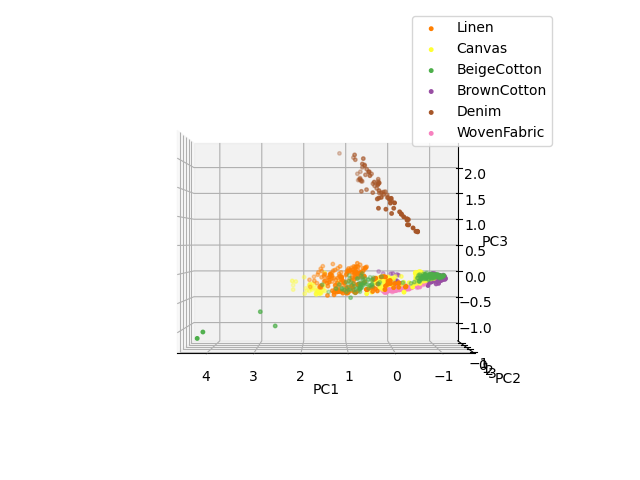

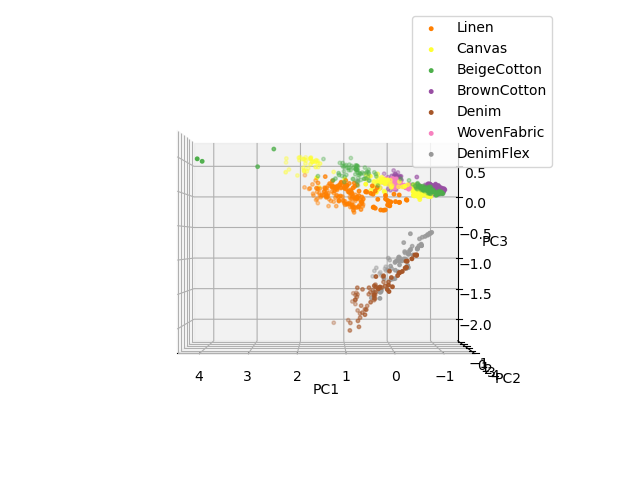

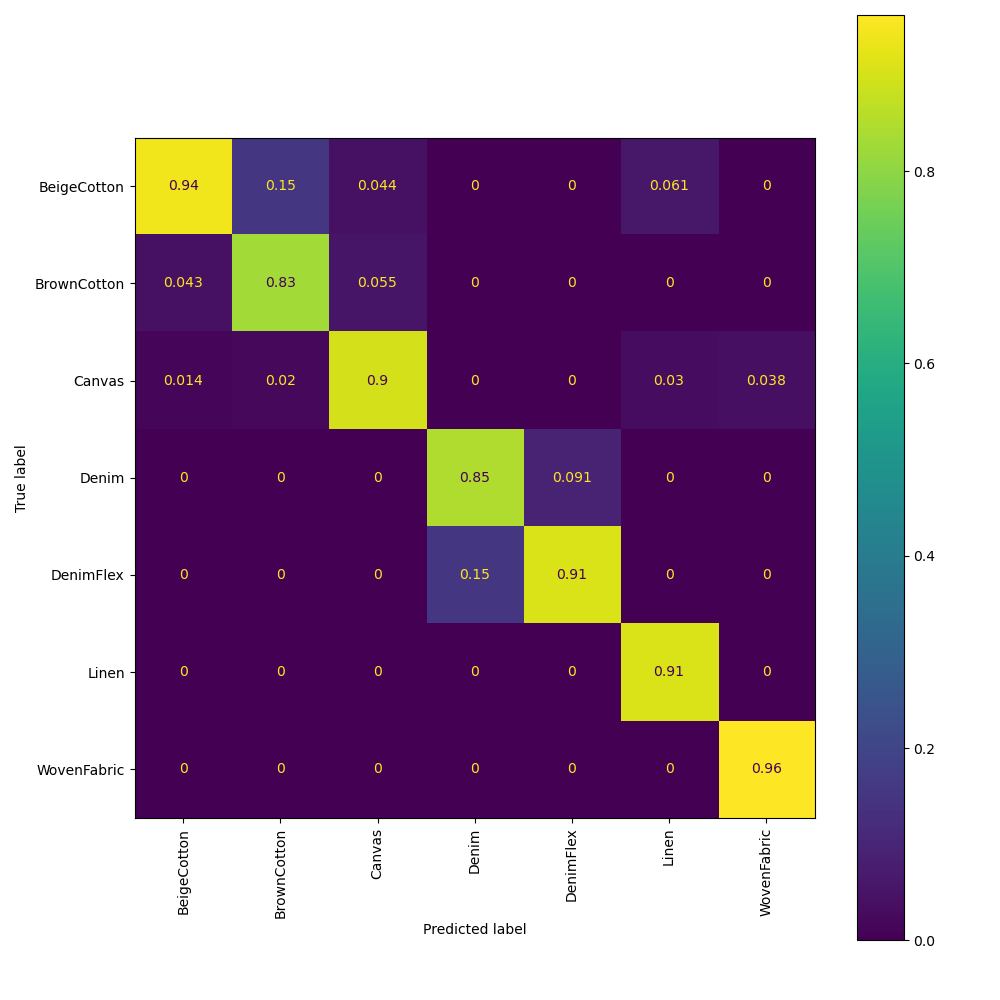

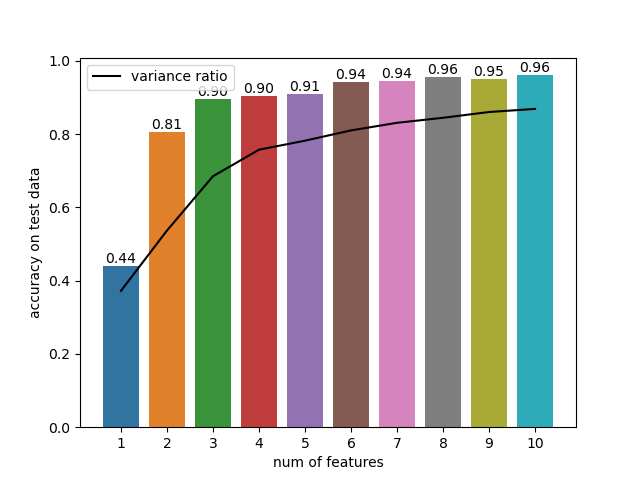

In [13]:
import seaborn as sns
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

%matplotlib widget

rate_list = []
ratio_list = []

for NPC in range(1, 11, 1):
    ipca = IncrementalPCA(n_components=NPC)
    train_x, train_y, test_x, test_y, other_x, other_y = split_train_test(
        coeffs, df_label, [2, 3], False
    )

    # Fit PCA feature extractor with initial training set
    # Transform train, test, other datasets into initial feature space
    ipca.partial_fit(train_x)
    trainXd = ipca.transform(train_x)
    testXd = ipca.transform(test_x)
    otherXd = ipca.transform(other_x)

    # Proceed with each test sample
    for new_tex in test_y["texture"].unique():
        select_id = test_y[test_y["texture"] == new_tex].index
        select_x = test_x[select_id, :]
        y_selected = test_y.iloc[select_id]

        # Transform the test point into feature space
        x = ipca.transform(select_x)

        if np.sum(select_x) > 0 and NPC == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
            plot3d(trainXd, train_y, "texture", ax=ax)
            plot3d(x, y_selected, "texture", ax=ax)
            ax.legend(loc="upper right", bbox_to_anchor=(1.05, 1.05))
            plt.tight_layout()
            plt.show()

        ipca.partial_fit(select_x)
        train_x = np.vstack([train_x, select_x])
        train_y = pd.concat([train_y, y_selected], axis=0)
        train_y.reset_index(drop=True, inplace=True)
        trainXd = ipca.transform(train_x)

    X_train, X_test, y_train, y_test = train_test_split(
        trainXd,
        train_y["texture"],
        stratify=train_y["texture"],
        test_size=0.5,
        random_state=1,
    )
    clf = KNeighborsClassifier(n_neighbors=10, weights="distance")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rate = accuracy_score(y_test, y_pred)
    rate_list.append(rate)
    var_ratio = np.sum(ipca.explained_variance_ratio_[:NPC])
    ratio_list.append(var_ratio)

    if NPC == 3:
        fig, ax = plt.subplots(figsize=(10, 10))
        ConfusionMatrixDisplay.from_estimator(
            clf, X_test, y_test, normalize="pred", xticks_rotation="vertical", ax=ax
        )
        plt.tight_layout()
        plt.show()

plt.figure()
g = sns.barplot(x=list(range(1, 11, 1)), y=rate_list)
l = sns.lineplot(
    x=list(range(0, 10, 1)), y=ratio_list, color="black", label="variance ratio"
)
for p in g.patches:
    g.annotate(
        "{:.2f}".format(p.get_height()),
        (p.get_x() + 0.4, p.get_height()),
        ha="center",
        va="bottom",
        color="black",
    )
plt.xlabel("num of features")
plt.ylabel("accuracy on test data")
plt.show()

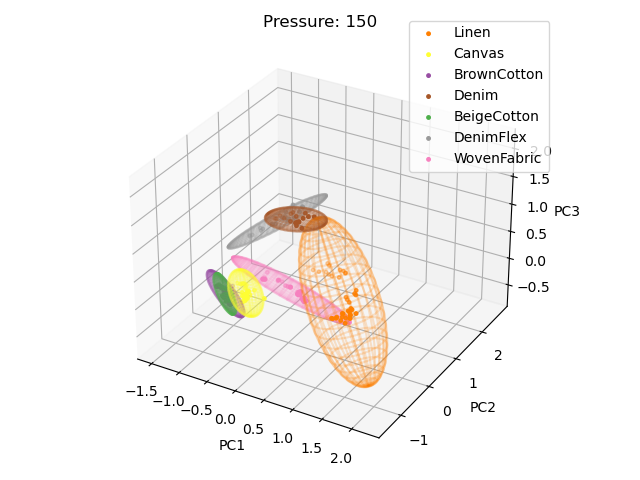

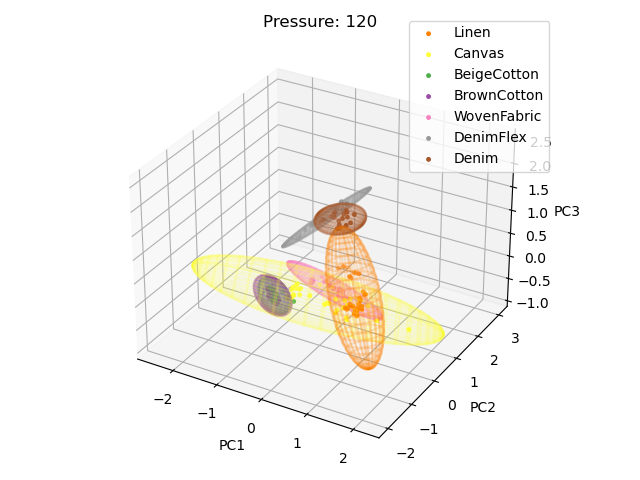

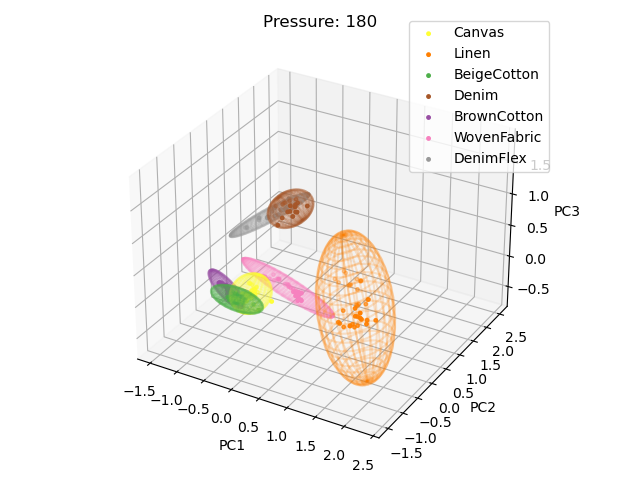

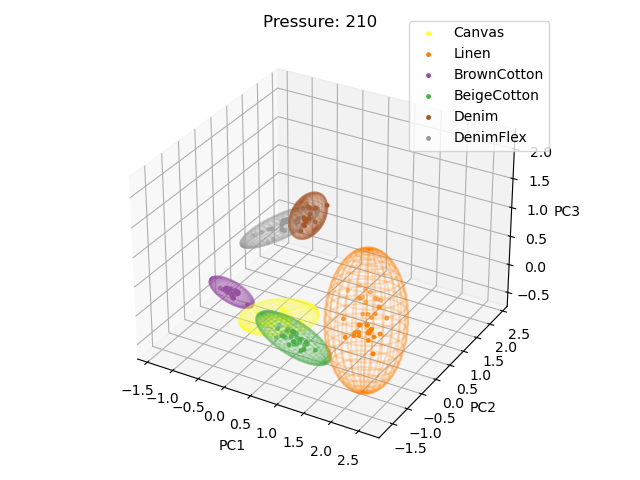

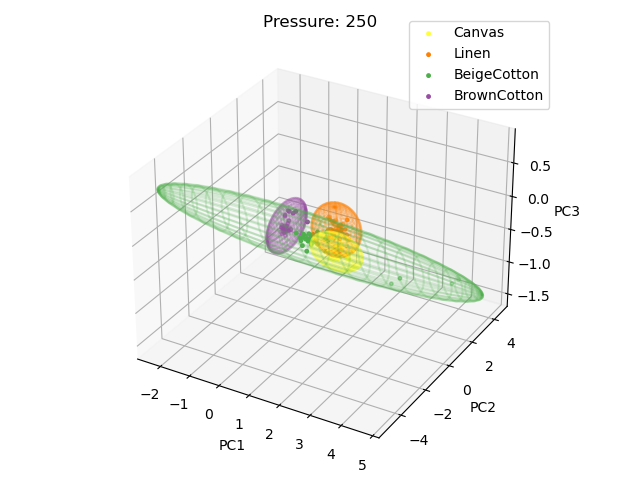

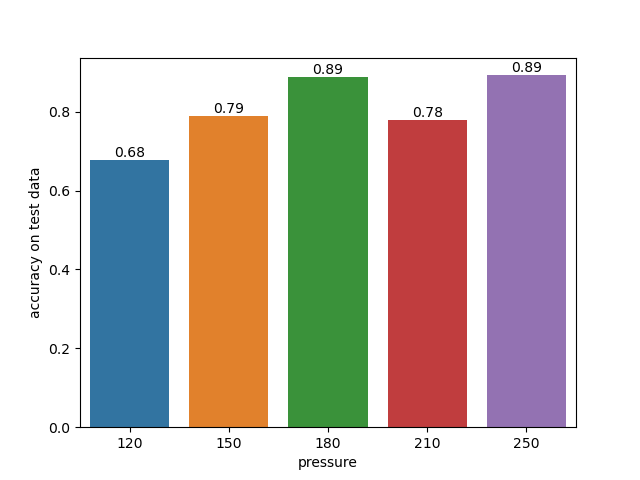

In [4]:
import numpy.linalg as LA

%matplotlib widget


class Ellipsoid:
    def __init__(self, x):
        if x.shape[1] > 3:
            x = x[:, :3]

        self.ctr = np.mean(x, axis=0)

        cov = np.matmul((x - self.ctr).transpose(), x - self.ctr)
        w, v = LA.eig(cov)

        self.axes = v * np.sqrt(w * 0.49)
        self.vol = 4.0 / 3.0 * np.pi / np.sqrt(w.prod())


def sep_measure(e1, e2):
    """Computer seperation measure for two ellipsoid"""
    if e1.vol > 0 and e2.vol > 0:
        R1 = np.abs(e1.ctr - e2.ctr)
        R2 = e1.vol * e2.vol
    else:
        return np.inf
    return R1 / R2


def plot_ellipsoid_3d(ell, ax, color):
    """Plot the 3-d Ellipsoid ell on the Axes3D ax."""

    # points on unit sphere
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    z = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    x = np.outer(np.ones_like(u), np.cos(v))

    # transform points to ellipsoid
    for i in range(len(x)):
        for j in range(len(x)):
            x[i, j], y[i, j], z[i, j] = ell.ctr + np.dot(
                ell.axes, [x[i, j], y[i, j], z[i, j]]
            )

    ax.plot_wireframe(x, y, z, rstride=4, cstride=4, color=color, alpha=0.2)


ipca = IncrementalPCA(n_components=3)

train_x, train_y, test_x, test_y, other_x, other_y = split_train_test(
    coeffs, df_label, [2, 3], False
)
x_fabric = np.vstack([train_x, test_x])
y_fabric = pd.concat([train_y, test_y], axis=0)
y_fabric.reset_index(drop=True, inplace=True)
coeffsXd = ipca.fit_transform(x_fabric)

rate_list_p = []
ellis = dict()

for pressure in y_fabric["pressure"].unique():
    index = y_fabric[y_fabric["pressure"] == pressure].index
    x = coeffsXd[index, :]
    y = y_fabric.iloc[index]
    y.reset_index(drop=True, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(
        x, y["texture"], stratify=y["texture"], test_size=0.9, random_state=1
    )
    clf = KNeighborsClassifier(n_neighbors=10, weights="distance")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rate = accuracy_score(y_test, y_pred)
    rate_list_p.append(rate)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    colordict = plot3d(x, y, "texture", ax=ax)
    plt.title("Pressure: {}".format(pressure))
    ellis[pressure] = dict()
    # Fit ellipsoids
    for tex in y["texture"].unique():
        ell_id = y[y["texture"] == tex].index
        ell = Ellipsoid(x[ell_id, :])
        ellis[pressure][tex] = ell.vol
        plot_ellipsoid_3d(ell, ax, colordict[tex])
    plt.tight_layout()
    plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1.05))
    plt.show()

plt.figure()
g = sns.barplot(x=y_fabric["pressure"].unique(), y=rate_list_p)
for p in g.patches:
    g.annotate(
        "{:.2f}".format(p.get_height()),
        (p.get_x() + 0.4, p.get_height()),
        ha="center",
        va="bottom",
        color="black",
    )
plt.xlabel("pressure")
plt.ylabel("accuracy on test data")
plt.show()

In [5]:
""" Plot only denims """
denims = ["Denim", "DenimFlex"]
marker = ["+", "o"]

train_x, train_y, test_x, test_y, other_x, other_y = split_train_test(
    coeffs, df_label, [2, 3], False
)
x_fabric = np.vstack([train_x, test_x])
fabric_label = pd.concat([train_y, test_y])
coeffsXd = ipca.fit_transform(x_fabric)

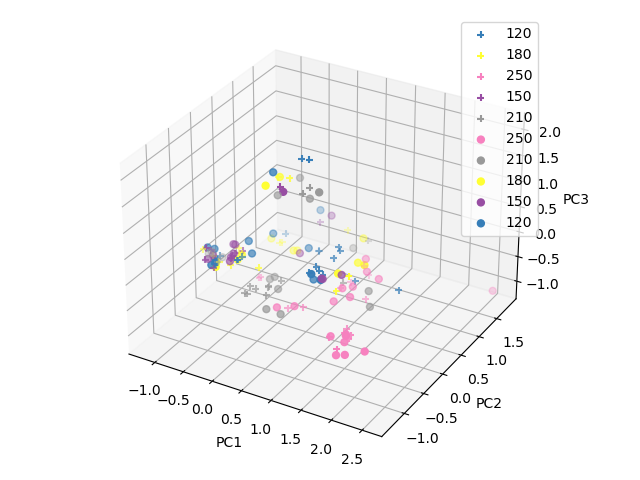

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for i, denim in enumerate(denims):
    denim_id = fabric_label[fabric_label["texture"] == denim].index
    denim_Xd = coeffsXd[denim_id, :3]
    denim_y = fabric_label.iloc[denim_id]
    plot3d(denim_Xd, denim_y, "pressure", ax=ax, marker=marker[i])
ax.legend()
plt.show()

NameError: name 'cmap' is not defined

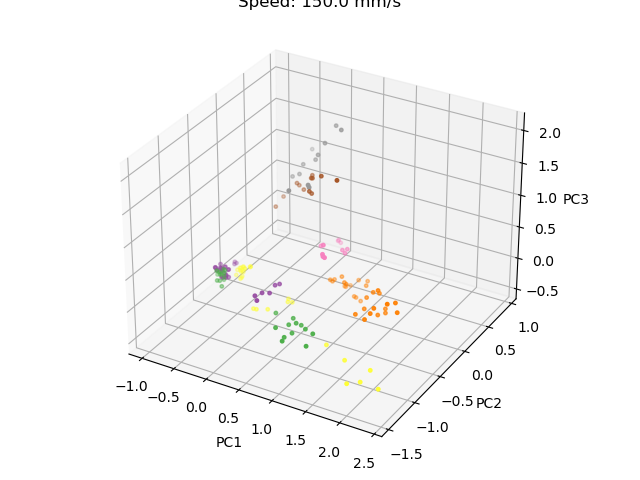

In [7]:
rate_list_s = []

y_fabric["speed"] = np.abs(y_fabric["speed"])
for speed in y_fabric["speed"].unique():
    index = y_fabric[y_fabric["speed"] == speed].index
    x = coeffsXd[index, :]
    y = y_fabric.iloc[index]

    X_train, X_test, y_train, y_test = train_test_split(
        x, y["texture"], stratify=y["texture"], test_size=0.9, random_state=1
    )
    clf = KNeighborsClassifier(n_neighbors=10, weights="distance")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rate = accuracy_score(y_test, y_pred)
    rate_list_s.append(rate)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    plot3d(x, y, "texture", ax=ax)
    plt.title("Speed: {} mm/s".format(speed))

    # Fit ellipsoids
    y.reset_index(drop=True, inplace=True)
    for tid in y["id"].unique():
        ell_id = y[y["id"] == tid].index
        ell = Ellipsoid(x[ell_id, :])
        plot_ellipsoid_3d(ell, ax, cmap(tid))
    plt.tight_layout()
    plt.legend(loc="upper left")
    plt.show()

plt.figure()
g = sns.barplot(x=y_fabric["speed"].unique(), y=rate_list_s)
for p in g.patches:
    g.annotate(
        "{:.2f}".format(p.get_height()),
        (p.get_x() + 0.4, p.get_height()),
        ha="center",
        va="bottom",
        color="black",
    )
plt.xlabel("speed (mm/s)")
plt.ylabel("accuracy on test data")
plt.show()

In [ ]:
ipca = IncrementalPCA(n_components=3)
train_x, train_y, test_x, test_y, other_x, other_y = split_train_test(
    coeffs, df_label, [2, 3], False
)

all_fabric = np.vstack([train_x, test_x])
# Fit PCA feature extractor with initial training set
# Transform train, test, other datasets into initial feature space
ipca.fit(all_fabric)
coeffsXd = ipca.transform(coeffs)
otherXd = ipca.transform(other_x)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
colordict = plot3d(coeffsXd, df_label, "texture", ax=ax)

other_y.reset_index(drop=True, inplace=True)
for tex in other_y["texture"].unique():
    ell_id = other_y[other_y["texture"] == tex].index
    ell = Ellipsoid(otherXd[ell_id, :])
    plot_ellipsoid_3d(ell, ax, colordict[tex])

plt.tight_layout()
plt.legend(loc="lower right")
plt.show()

# Plot One Sample in Both Time and Frequency Domain

In [ ]:
import matplotlib.pyplot as plt

%matplotlib widget

ds = TacDataset("data", transform=None)
transformer = ResampleFFT(64)
cmap = plt.cm.get_cmap("tab20", 16)

sample, param, label = ds[119]
x = sample
y = transformer(x)
freq = np.linspace(1, 32, 64)

fig1, ax1 = plt.subplots(figsize=(9, 5), nrows=1, ncols=1)
fig1.subplots_adjust(right=0.8)

fig2, ax2 = plt.subplots(figsize=(9, 5), nrows=1, ncols=1)
fig2.subplots_adjust(right=0.8)

for i in range(16):
    ax1.plot(x[:, i], c=cmap(i), label="channel {}".format(i + 1))
    ax2.plot(freq, y[:, i], c=cmap(i), label="channel {}".format(i + 1))


ax1.set_ylabel("sensor values")
ax1.set_xlabel("time(s)")
ax1.set_title(
    "{} @ pressure: {}, speed: {}mm/s".format(
        ds.get_texture_name(label), param[0], param[1]
    )
)

ax2.set_xlabel("frequency(Hz)")
ax2.set_ylabel("strength")
ax2.set_title(
    "{} @ pressure: {}, speed: {}mm/s".format(
        ds.get_texture_name(label), param[0], param[1]
    )
)

ax1.legend(loc="center left", bbox_to_anchor=(0.8, 0.5))
ax2.legend(loc="center left", bbox_to_anchor=(0.8, 0.5))
plt.show()